## Conceptual issues - July 26
### 1. Speed-density relation (most urgent)
Our speed density relation is:
$$
avg\_speed(kc) = \left(\frac{v_f}{\frac{\frac{\pi}{2} - \arctan(a * (-kc_{half,jam}))}{\pi}}\right) \left(\frac{\frac{\pi}{2} - \arctan(a * (kc - kc_{half,jam}))}{\pi} \right)
$$

Simplified, that is
$$
avg\_speed(kc) = \left(\frac{v_f}{\frac{\pi}{2} - \arctan(a * (-kc_{half,jam}))} \right) \left( \frac{\pi}{2} - \arctan(a * (kc - kc_{half,jam})) \right)
$$
where the variable $kc$ is population density in a corridor, parameter $v_f$ is free-flow velocity, parameter $a$ controls the steepness of the arctan function, and parameter $kc_{half,jam}$ is the density value of $kc$ at which the arctan function reaches an inflection point. 

In this speed-density relation, **I thought** that `kc_half_jam` always represented the density at which average velocities drop to 1/2 of v_f (free-flow velocity). That is, I thought that the inflection point would always occur at $avg\_speed = \frac{1}{2} v_f$. **It turns out this isn't true**. To see this, do the following in the code chunk below:

- Try plotting $avg\_speed$ with `v_f_base=90`, `a=20`, and `kc_half_jam=0.5`. Observe that the y-intercept (green line) is `(kc,avg_speed) = (0,90)`, as expected, and at `kc=kc_half_jam`, we have `avg\_speed(kc_half_jam) = 46.47` (purple line). This is very close to half of `v_f` (but not exactly, which should have tipped me off about the problem we will face). Also notice to the left of the y-axis, the speed-density curve levels off at a value just a little above $v=90$.
- Now set `kc_half_jam=0.01` and run the code again. We still have the y-intercept at `(kc,avg_speed) = (0,90)` (green line). But now at `kc=kc_half_jam`, we have `avg\_speed(kc_half_jam) = 79.95` (purple line). Also notice to the left of the y-axis, the speed-density curve exceeds $v=150$ and has not yet leveled off.

What does this mean? The inflection point of the function is *not* where $avg\_speed = \frac{1}{2} v_f$. This is probably one of the reasons why changing `kc_half_jam` doesn't seem to lead to significantly longer rush-hour periods; everytime we decrease `kc_half_jam`, we are implicitly increasing average velocities! So when we try to make corridors smaller (and more prone to congestion), we are also making them faster (less prone to congestion).

### What can we do?
One option is to go back to try and tweak the functional form of our speed-density relation so that `kc_half_jam` has the meaning we want. 

Another option is to switch to using an existing speed-density relation from the literature. Some options outlined in "Genealogy of traffic flow models" (Fig 4) (https://www.sciencedirect.com/science/article/pii/S2192437620301114) include:
- Daganzo (1994): Daganzo CF (1994) The cell transmission model: a dynamic representation of highway traffic consistent with the hydrodynamic theory. Transp Res Part B Methodol 28(4):269–287
    - https://www.sciencedirect.com/science/article/pii/0191261594900027
- Smulders et al. (1990): Smulders S (1990) Control of freeway traffic flow by variable speed signs. Transp Res Part B Methodol 24(2):111–132
    - https://www.sciencedirect.com/science/article/pii/019126159090023R
- Drake et al. (1967): Drake JS, Schofer JL, May AD (1967) A statistical analysis of speed–density hypotheses. Highw Res Rec 154:53–87
    - Couldn't find a link...

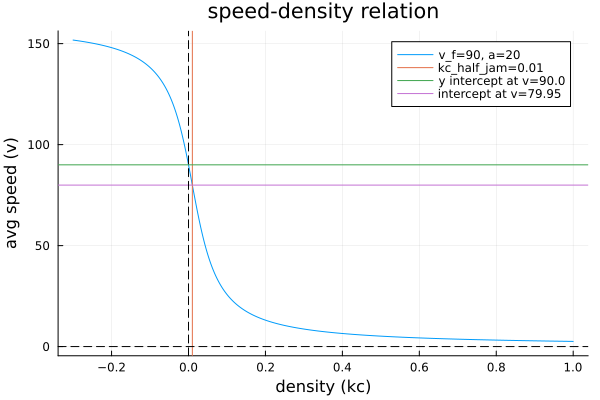

In [37]:
using Plots

# Define speed-density curve
η(a, kc, kc_half_jam) = (pi / 2 .- atan.(a .* (kc .- kc_half_jam))) ./ pi # arctan function with inflection point at kc_half, asymptotically approaches y=0
ϕ(a, kc, kc_half_jam) = η(a, kc, kc_half_jam) ./ η(a, 0.0, kc_half_jam)        # rescale so y-range is (0,1)
avg_speed(v_f, a, kc, kc_half_jam) = v_f .* ϕ(a, kc, kc_half_jam)

# Define range of densities (kc) to test
my_kc_range = [-0.3:0.001:1.0;]

# Define parameters
v_f_base = 90 # v_f in kmh
v_f = v_f_base / 60 # convert v_f to km per minute
a = 20
kc_half_jam = 0.01

# Calculate and plot average speeds for the test densities
my_speeds_test = avg_speed.(v_f, a, my_kc_range, kc_half_jam) .* 60
plt = plot(my_kc_range, my_speeds_test, label="v_f=$v_f_base, a=$a", title="speed-density relation", ylabel="avg speed (v)", xlabel="density (kc)")
plt = vline!(plt, [kc_half_jam], label="kc_half_jam=$kc_half_jam")

# Calculate and plot y-intercept and interception with kc_half_jam
intercept_y_axis = avg_speed.(v_f, a, 0, kc_half_jam) .* 60
intercept_kc_half_jam = avg_speed.(v_f, a, kc_half_jam, kc_half_jam) .* 60
plt = hline!(plt, [intercept_y_axis], label="y intercept at v=$intercept_y_axis")
plt = hline!(plt, [intercept_kc_half_jam], label="intercept at v=$(round(intercept_kc_half_jam; digits = 2))")

# Highlight x and y axes
plt = vline!(plt, [0], label=false, color="black", linestyle=:dash)
plt = hline!(plt, [0], label=false, color="black", linestyle=:dash)

display(plt)

### 2. Travelers (can) arrive ~instantaneously to their destination (high priority)
Our current model calculates `EntryFlux` and `ExitFlux` as a function of current population densities in patches (`kp`) and on corridors (`kc`). There is no accounting for the *length* of corridors. Thus, if there is little congestion, vehicles may leave a patch, enter a corridor, and then exit into their destination patch within two time-steps. 

This will be a problem when we want to compute total emissions. In order to get an accurate count of total emissions, we need to integrate emission rates over the *time that vehicles are traveling*. If vehicles can arbitrarily travel nearly instantaneously from their origin to their destination, it will look like they are producing emissions for a very short period of time. Even when vehicles don't travel instantaneously (e.g. they are slowed down by congestion), this still does not reflect the actual length of time they must be in motion in order to cross the distance from origin to destination.

If a corridor is 10km, my time-in-motion should (usually) be different than it would be if the corridor were only 1km. 

Why is this happening? The flux equation `q = v * k` refers to flux across a discrete area of space (imagine a traffic camera pointed at a slice of highway). At the moment, our `EntryFlux` and `ExitFlux` effectively only cares about what happens at the point of entering a highway and the point of exiting. It's as if we only care about flux across a discrete space (where the traffic camera points). We are not saying anything about the length of space that a vehicle must traverse between entering and exiting a highway.

This matters now because we want to start choosing our parameters according to some realistic scenarios, which involves thinking about "lane-kms". We can certainly imagine a 4-lane highway stretched across 10km and choose parameters like `kc_half_jam` for such a corridor. But I predict that our "rush hour" periods will be much shorter than we would expect realistically.

### 3. Demand function and flux functions (a caution of interpretation)
Our function $\gamma$ captures demand for *leaving* patches, as a function of time of day. The value of $\gamma$ can range from 0 to 1; in our current iteration, it ranges from 0 to 0.5. Then, our flux function for leaving patches and entering corridors looks like this:

```
EntryFlux(kp, kc, γ, α, kc_half_jam, v_f, λ) = avg_speed(λ, v_f, a, kc, kc_half_jam) .* kp .* γ .* time_rescale
```

This function `EntryFlux` is then part of our ODE system (relevant excerpt shown below)
```
eqs = [
    D.(kp) ~ [sum(ExitFlux(kc, kc_half_jam, v_f, λ)[:, i, :]) for i in 1:Np] .- [sum(EntryFlux(kp, kc, γ, α[1], kc_half_jam, v_f, λ)[i, :, :]) for i in 1:Np],
    D.(kc) ~ collect(-ExitFlux(kc, kc_half_jam, v_f, λ) + EntryFlux(kp, kc, γ, α[1], kc_half_jam, v_f, λ)),
    γ[1] ~ f(v_shifted(shift), r, x_0, L),
    γ[2] ~ f(-v_shifted(shift), r, x_0, L)
]
```
This means that `EntryFlux` is being calculated at each time step (size `dt`) in our dynamical system.

Suppose $\gamma[1] = 0.5$ for all time, and that the initial condition for `kp[1]=1.0` (100% of the total population is in patch 1). For simplicity, let's suppose `dt=0.01`. At the first time step, that means our "effective population" that wants to leave patch 1 is `0.5 * kp[1](t=0) = 0.5`. So some of patch 1's population leaves, and now the remainng population in patch 1 is smaller: let's say `kp[1](t=0.1) = 0.95`. Now we run the equations again: this time, the "effective population" that wants to leave patch 1 is `0.5 * 0.95 = 0.475`. Again, some people leave. And so on. As long as $\gamma[1] > 0$, there are always some people who want to leave patch 1.

This is fine if we want it to be this way. But we need to be careful. By saying $\gamma=0.5$, one might assume we mean "50% of the population of patch 1 wants to leave, the other 50% wants to stay." Such an interpretation would imply that, once half of patch 1's population has left, everyone else will *not* want to leave. As our code is written, that implication would not be true.

### 4. Demand "to", not just demand "from" (a future issue)
Once we have `Np > 2`, we will need to think about "attraction" *to* patches, not just "demand" *from* patches. 

In many transportation engineering models, a gravity model is used, where `R` (the distance between two bodies) is given by the "impedence" (think of this like a "friction factor"). Impedence is sometimes defined as e.g. total trip time, trip cost, inverse jam density, etc. or some combination of multiple factors.